# **D212 Performance Assessment 1:** Clustering  

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Churn  
---

### *Research Question*  

Can we cluster our customers based on their tenure and bandwidth consumption?

## Initialization
---

In [3]:
#import needed libraries
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import RobustScaler

#allow pd.describe to show all columns of the data frame [In-Text Citation: (Ray, 2020)]
pd.options.display.max_columns = None 

#Initialize some lists to speed cleansing
numerical_variables = ['Tenure','Bandwidth_GB_Year']

#load church_missing_data.csv
df = pd.read_csv('churn_clean.csv', keep_default_na=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

## Cleaning
---

In [4]:
# Check duplicated data
df.duplicated(subset = None)

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

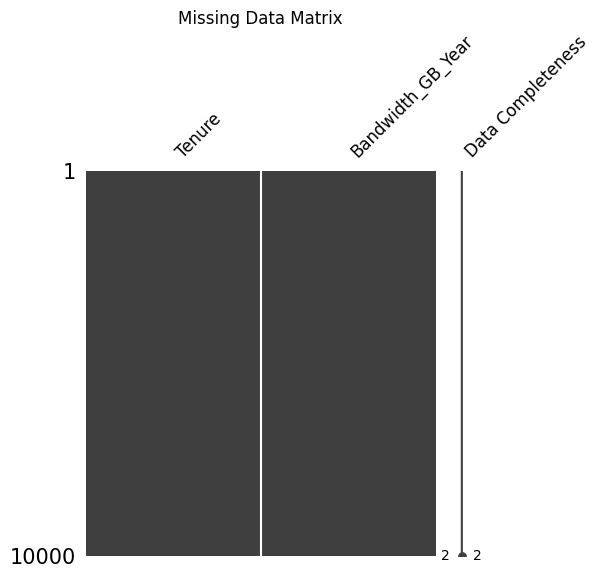

In [5]:
# Check missing data
msno.matrix(df[numerical_variables], fontsize = 12, labels=True, figsize=(5,5))
plt.title('Missing Data Matrix')
plt.show()

In [6]:
#Detect potential outliers
df_z = (df[numerical_variables] - df[numerical_variables].mean())/df[numerical_variables].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    minval, maxval = df[col].min(), df[col].max()
    print('Likely outlier for {0:<20}\t Count: {1:7d} ({2:5.2%} of observations)\tMin: {3:>9.2f}\tMax: {4:>9.2f}'.format(col,cnt,cnt/10000,minval,maxval))

## EDA
---

In [7]:
# Independent numerical variables
for col in numerical_variables :
    print(f'{col} :')
    print(df[col].describe())

Tenure :
count    10000.000000
mean        34.526188
std         26.443063
min          1.000259
25%          7.917694
50%         35.430507
75%         61.479795
max         71.999280
Name: Tenure, dtype: float64
Bandwidth_GB_Year :
count    10000.000000
mean      3392.341550
std       2185.294852
min        155.506715
25%       1236.470827
50%       3279.536903
75%       5586.141370
max       7158.981530
Name: Bandwidth_GB_Year, dtype: float64


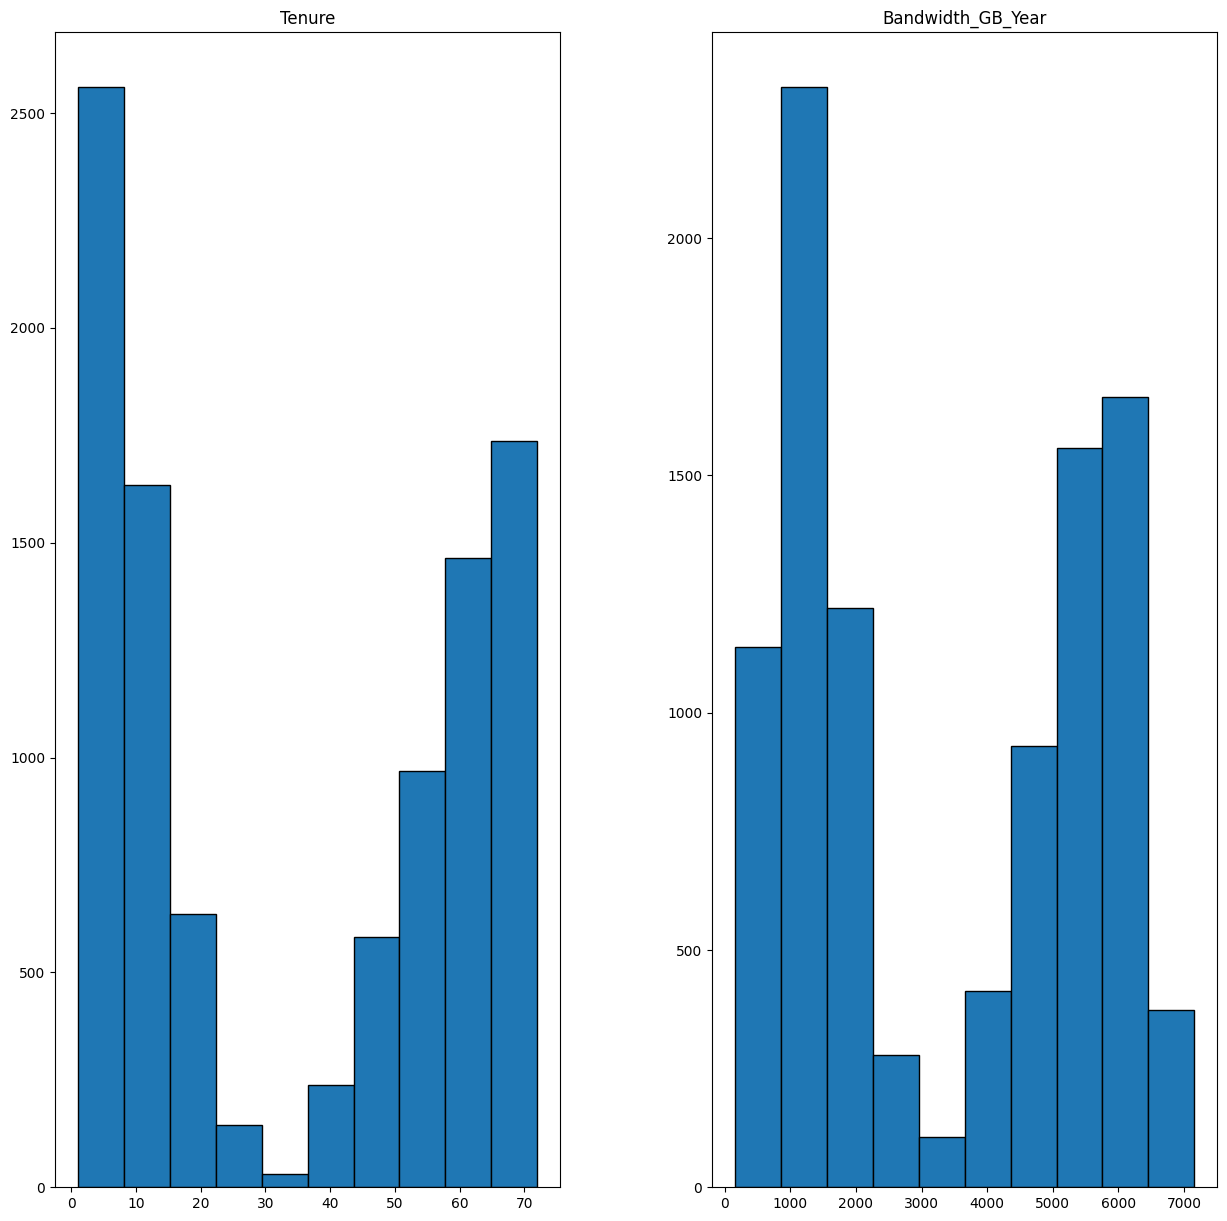

In [8]:
# Independent numeric variables univariate
df[numerical_variables].hist(numerical_variables, grid=False, edgecolor='black', figsize=(15,15))
plt.show()

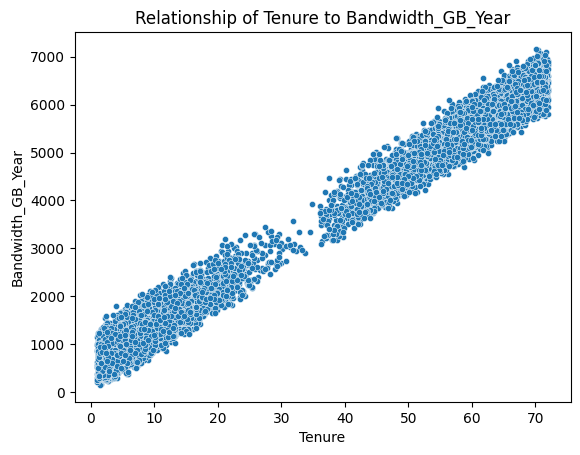

In [9]:
sns.scatterplot(data=df, x='Tenure', y='Bandwidth_GB_Year', s = 20)
plt.title(f'Relationship of Tenure to Bandwidth_GB_Year')
plt.show()

## Transformation
---

In [10]:
# Scaling (Nalcin, 2022)
scaler = RobustScaler()
scaled = scaler.fit_transform(df[numerical_variables])
df_scaled = pd.DataFrame(scaled, columns = numerical_variables)
print(df_scaled.describe().round(2))

         Tenure  Bandwidth_GB_Year
count  10000.00           10000.00
mean      -0.02               0.03
std        0.49               0.50
min       -0.64              -0.72
25%       -0.51              -0.47
50%        0.00              -0.00
75%        0.49               0.53
max        0.68               0.89


In [11]:
# Extract prepared data set to CSV
df_scaled.to_csv('churn_prepared.csv', index=False)

## Analysis
---

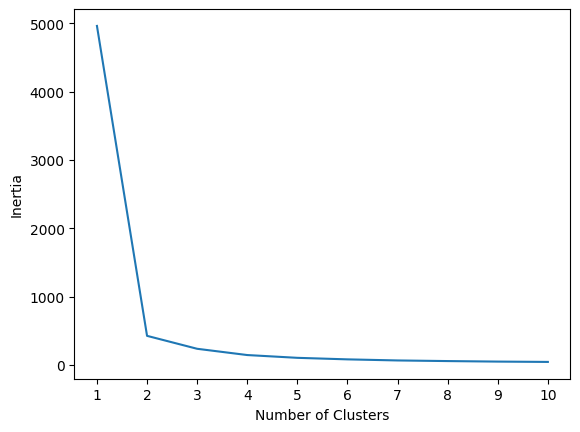

In [12]:
# Find optimal number of clusters  (Bobbitt, 2023)

# Initialize kmeans parameters
kmeans_args = {
    "init": "random",
    "n_init": 50,
    "random_state": 1,
}

n_clusters_range = range(1,11)
interias = []

# Fit KMeans with different n_clusters and save SSE 
for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, **kmeans_args)
    kmeans.fit(df_scaled)
    interias.append(kmeans.inertia_)

#visualize results
plt.plot(n_clusters_range, interias)
plt.xticks(n_clusters_range)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [13]:
# Create kmeans with optimal number of clusters
kmeans = KMeans(n_clusters=2, **kmeans_args)
labels = kmeans.fit_predict(df_scaled)
df_scaled['cluster'] = labels
df['cluster'] = labels

## Model Evaluation
---

In [14]:
# Display additional metrics (Savare, 2024) and (Amelia, 2018)

inertia = kmeans.inertia_
silhouette = silhouette_score(df_scaled, labels)
db = davies_bouldin_score(df_scaled, labels)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Boudlin: ", db)

Inertia: 424.7817343340924
Silhouette Score: 0.8557853355931535
Davies-Boudlin:  0.2044450830874846


     Tenure  Bandwidth_GB_Year
0 -0.490958          -0.452275
1  0.457381           0.504335


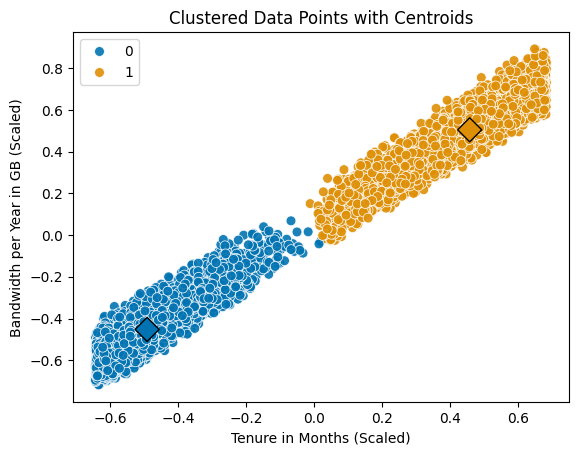

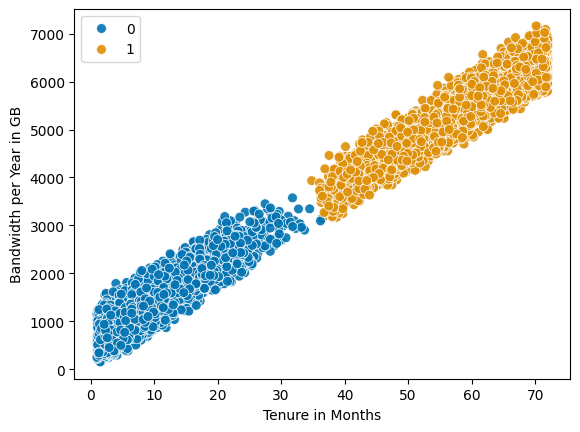

In [15]:
# Evaluate centroids (Kamara, n.d.)
centroids = pd.DataFrame(kmeans.cluster_centers_, 
                        columns = numerical_variables)
print(centroids)

# Plot scaled points and centroids
ax = sns.scatterplot(data = df_scaled,
                    x = 'Tenure',
                    y = 'Bandwidth_GB_Year', 
                    hue = labels,
                    palette = 'colorblind',
                    alpha = 0.9,
                    s = 50,
                    legend = True)
ax = sns.scatterplot(data = centroids,
                    x = 'Tenure',
                    y = 'Bandwidth_GB_Year', 
                    hue = centroids.index,
                    palette = 'colorblind',
                    s = 150,
                    marker = 'D',
                    ec = 'black',
                    legend = False)
plt.title('Clustered Data Points with Centroids')
plt.xlabel('Tenure in Months (Scaled)')
plt.ylabel('Bandwidth per Year in GB (Scaled)')
plt.show()

# Plot original points
sns.scatterplot(data = df,
                    x = 'Tenure',
                    y = 'Bandwidth_GB_Year', 
                    hue = labels,
                    palette = 'colorblind',
                    alpha = 0.9,
                    s = 50,
                    legend = True)
plt.xlabel('Tenure in Months')
plt.ylabel('Bandwidth per Year in GB')
plt.show()

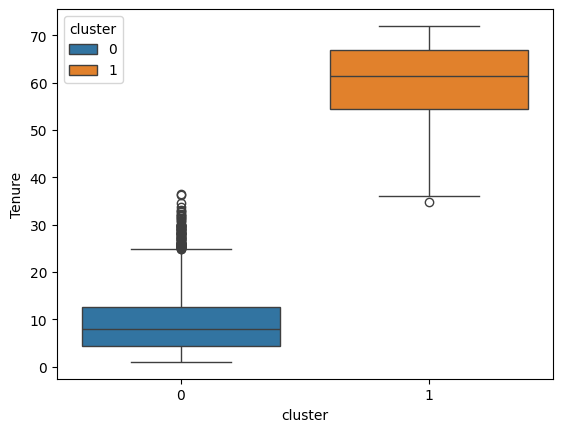

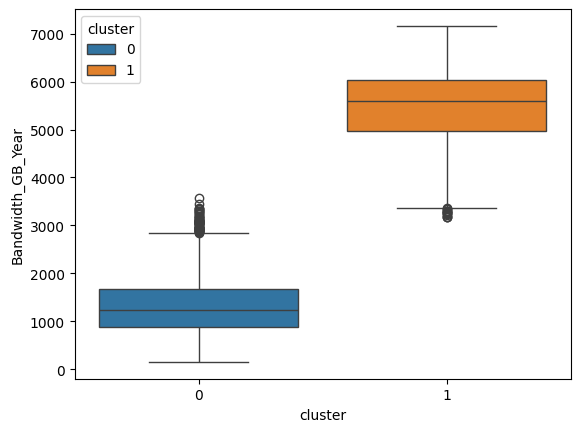

In [16]:
# Boxplots of study variables
sns.boxplot(data=df, x = 'cluster', y = 'Tenure', hue='cluster')
plt.show()
sns.boxplot(data=df, x = 'cluster', y = 'Bandwidth_GB_Year', hue='cluster')
plt.show()